In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import glob
import pandas as pd
import numpy as np
import astropy.units as u
from datetime import date
from random import choices, seed
from math import factorial, erf
from astroquery.simbad import Simbad
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm, uniform, truncnorm
from scipy.special import erfinv, comb
from scipy.special import comb
import h5py
from sklearn.neighbors import KernelDensity
from scipy.integrate import simps
from scipy import stats
from matplotlib.ticker import AutoMinorLocator
from astropy.io import ascii
from IPython.display import clear_output
import time
from scipy.signal import find_peaks


In [2]:
def make_cmap(colors, position, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    bit_rgb = np.linspace(0,1,256)
    # if position == None:
    #     position = np.linspace(0,1,len(colors))
    # else:
    if len(position) != len(colors):
        sys.exit("position length must be the same as colors")
    elif position[0] != 0 or position[-1] != 1:
        sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
def choose_cmap(custom_cmap, reverse_cmap=False):

    custom_cmaps = {'primordial disks': [(0/255, 26/255, 26/255),
                                         (41/255, 163/255, 163/255),
                                         (179/255, 255/255, 217/255)],
                    'debris disks': [(15/255, 15/255, 62/255),
                                      (102/255, 102/255, 255/255),
                                      (255/255, 204/255, 255/255)],
                    'hot jupiters': [(15/255, 15/255, 62/255),
                                     (102/255, 102/255, 255/255),
                                     (255/255, 250/255, 255/255)],
                    'warm jupiters': [(51/255, 26/255, 0/255),
                                      (255/255, 80/255, 80/255),
                                      (255/255, 255/255, 204/255)],
                    'cyber grape': [(51/255, 0/255, 51/255),
                                    (128/255, 0/255, 128/255),
                                    (153/255, 102/255, 255/255),
                                    (204/255, 255/255, 255/255)],
                    'raspberry punch1': [(51/255, 0/255, 102/255),
                                        (51/255, 204/255, 224/255),
                                        (248/255, 255/255, 230/255)],
                    'raspberry punch2': [(70/255, 0/255, 0/255),
                                        (89/255, 0/255, 179/255),
                                        (51/255, 204/255, 224/255),
                                        (255/255, 255/255, 200/255)],
                    'raspberry punch': [(51/255, 0/255, 102/255),
                                        # (89/255, 0/255, 179/255),
                                        (51/255, 204/255, 224/255),
                                        (255/255, 255/255, 200/255)],
                    }

    chosen_cmap = custom_cmaps[custom_cmap]
    pos_diff = 1./(len(chosen_cmap)-1)
    positions = np.arange(0, 1+pos_diff, pos_diff)
    if reverse_cmap == True:
        chosen_cmap = chosen_cmap[::-1]
    mycolormap = make_cmap(chosen_cmap, position=positions)

    return mycolormap

plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')
# plt.rcParams.keys()

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [3]:
def true_obliquity_posterior(i_star_deg, i_plane_deg, dx, verbose=False):
    # Compute the posterior distribution conditioned on the stellar inclination angle and inclination of the disk or orbital plane

    if isinstance(i_star_deg, np.ndarray) or isinstance(i_star_deg, list):
        i_star_deg = np.mean(i_star_deg)
        # print('i_star_deg is np.ndarray!')
    if isinstance(i_plane_deg, np.ndarray) or isinstance(i_plane_deg, list):
        i_plane_deg = np.mean(i_plane_deg)
        # print('i_plane_deg is np.ndarray!')

    if verbose == True:
        print('i_star_deg', i_star_deg)
        print('i_plane_deg', i_plane_deg)
        print('abs(i_plane_deg - i_star_deg): ', abs(i_plane_deg - i_star_deg))
        print('abs(i_plane_deg + i_star_deg): ', i_plane_deg + i_star_deg)


    all_obliquities_deg = np.arange(0, 180 + dx, dx)

    all_obliquities_rad = []
    for obl in range(len(all_obliquities_deg)):
        all_obliquities_rad.append(np.radians(all_obliquities_deg[obl]))
    all_obliquities_rad = np.array(all_obliquities_rad)


    true_obliquities_deg = all_obliquities_deg[(all_obliquities_deg > abs(i_plane_deg - i_star_deg)) & (all_obliquities_deg < (i_plane_deg + i_star_deg))]
    # if true_obliquities_deg[0] == true_obliquities_deg[-1]:
    #     i_star_deg += (4 * dx)
    #     true_obliquities_deg = all_obliquities_deg[(all_obliquities_deg > abs(i_plane_deg - i_star_deg)) & (all_obliquities_deg < (i_plane_deg + i_star_deg))]
    # print('true_obliquities_deg: ', true_obliquities_deg[0], true_obliquities_deg[-1], '\n')

    true_obliquities_rad = []
    for obl in range(len(true_obliquities_deg)):
        true_obliquities_rad.append(np.radians(true_obliquities_deg[obl]))
    true_obliquities_rad = np.array(true_obliquities_rad)
    # print('true_obliquities_rad', true_obliquities_rad[0:10], '\n')
    
    i_star_rad = np.radians(i_star_deg)
    i_plane_rad = np.radians(i_plane_deg)

    top = np.sin(i_star_rad) * np.sin(true_obliquities_rad)
    bottom1 = np.sin(true_obliquities_rad)**2 * np.sin(i_plane_rad)**2
    bottom2 = (np.cos(true_obliquities_rad) * np.cos(i_plane_rad) - np.cos(i_star_rad))**2
    # print('top', top[0:10], '\n')
    # print('bottom1', bottom1[0:10], '\n')
    # print('bottom2', bottom2[0:10], '\n')

    posterior = top / np.sqrt(abs(bottom1 - bottom2))

    # print(true_obliquities_rad)

    true_obliquities = []
    for obl2 in range(len(true_obliquities_rad)):
        true_obliquities.append(np.degrees(true_obliquities_rad[obl2]))

    posterior = posterior / (sum(posterior) * dx)
    posterior[0] = posterior[-1]

    
    full_posterior = np.zeros_like(all_obliquities_deg)

    if verbose == True:
        print('true obliquities deg limits: [{:2f},{:.2f}]'.format(true_obliquities_deg[0], true_obliquities_deg[-1]), '\n')

    full_posterior[(all_obliquities_deg > abs(i_plane_deg - i_star_deg)) & (all_obliquities_deg < (i_plane_deg + i_star_deg))] = posterior



    return all_obliquities_deg, full_posterior

In [4]:
def draw_data_for_kde(Prob_distributions, posterior_x_values, kde_n_draws, verbose=False):

    # ------------------ GENERATE ARRAY OF DRAWS FROM ALL PROBABILITY DISTRIBUTIONS ------------------ #

    data_for_kde = []

    posterior_x_values = np.concatenate(([0], posterior_x_values))
    if verbose == True:
        print('population (min, max):', min(posterior_x_values), ',', max(posterior_x_values))
        print('len population: ', len(posterior_x_values), 'len weights: ', len(Prob_distributions[0]))
    for prob_i in Prob_distributions:
        if sum(prob_i) == 0:
            prob_i += 1e-9
        data_for_kde.extend(choices(posterior_x_values, prob_i, k=kde_n_draws))

    data_for_kde = np.array(data_for_kde).reshape(-1, 1)

    return data_for_kde

def generate_kde(data_for_kde, posterior_x_values, dx, kde_bandwidth):

    bep1 = np.array(posterior_x_values)
    bep2 = bep1[-1] + bep1[1::]
    x_values = np.concatenate((bep1, bep2))
    # print('original_i_values: ', bep1[0:3], bep1[-3::], '\n')
    # print(bep2[0:10], bep2[-10::])
    # print('long_i_values:', i_values[0:3], i_values[-3::], '\n')

    reverse_negative_x_values = -x_values[::-1][:-1]
    x_values_mirrored_across_zero = np.concatenate((np.array(reverse_negative_x_values), np.array(x_values)))
    # print('i_values_mirrored_across_zero: ', i_values_mirrored_across_zero[0:3], i_values_mirrored_across_zero[-3::], '\n')
    x_grid_all = np.array(x_values_mirrored_across_zero).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=kde_bandwidth).fit(data_for_kde)
    log_density = kde.score_samples(x_grid_all)

    density_estimation = np.array(np.exp(log_density))

    density_estimation_mirrored_across_zero = density_estimation[::-1]
    density_estimation_total_across_zero = density_estimation + density_estimation_mirrored_across_zero


    density_estimation_total_across_zero_positive_ivalues = density_estimation_total_across_zero[x_values_mirrored_across_zero >= 0]
    positive_x_values = x_values_mirrored_across_zero[x_values_mirrored_across_zero >= 0]
    # print('positive_i_values: ', positive_i_values[0:3], positive_i_values[-3::], '\n')

    density_estimation_mirrored_across_max = density_estimation_total_across_zero_positive_ivalues[::-1]
    density_estimation_total_across_max = density_estimation_total_across_zero_positive_ivalues + density_estimation_mirrored_across_max


    density_estimation_total = density_estimation_total_across_max[positive_x_values <= max(posterior_x_values)]
    original_x_values = positive_x_values[positive_x_values <= max(posterior_x_values)]
    # print('original_i_values: ', original_i_values[0:3], original_i_values[-3::], '\n')
    # print(' ')

    density_estimation_total = density_estimation_total / (sum(density_estimation_total) * dx)
    
    return density_estimation_total


In [15]:
tepcat = pd.read_csv("/Users/lib278/Documents/Manuscripts/OBLIQUITY_SYNTHESIS/Tables/Literature_Tables/TEPCAT.csv")
tepcat = tepcat[tepcat['Psi'] != -999.0]
tepcat = tepcat[tepcat['Teff'] < 6400]
tepcat = tepcat[tepcat['Psi'] != -1]
tepcat = tepcat[tepcat['M_b'] >= 1]
tepcat = tepcat[tepcat['M_b'] <= 13]
tepcat

done_list = []
retrograde_counts = 0

for system in tepcat['System']:

    if system not in done_list:

        system_dat = tepcat[tepcat['System'] == system]
        system_psi = np.mean(system_dat['Psi'])
        print(system, system_psi)
        done_list.append(system)

        if system_psi > 90:
            retrograde_counts += 1

regrograde_fraction = retrograde_counts/len(tepcat['System'])

print('\n{:d}/{:d}'.format(retrograde_counts, len(tepcat['System'])))
print('retrograde_fraction', regrograde_fraction)






CoRoT-18 20.0
HAT-P-07 115.0
HAT-P-20 36.0
HAT-P-22 24.0
HAT-P-36 0.0
HATS-02 38.0
HD_118203 0.0
HD_189733 13.6
K2-267 3.4
Kepler-017 0.0
TOI-4201 21.3
WASP-043 0.0

1/12
retrograde_fraction 0.08333333333333333


54.0
22.0


/var/folders/d1/1tgqc089191cw1n9by3bdp_nm479yx/T/ipykernel_70973/2660258401.py:61: RuntimeWarning: invalid value encountered in divide
  Prob_Psi_copy = Prob_Psi_copy / (np.sum(Prob_Psi_copy) * dx)


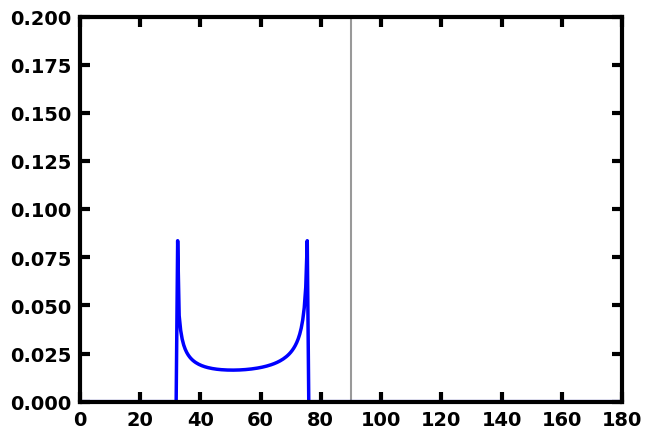

In [114]:
dx = 0.5
possible_is = np.arange(dx, 90 + dx, dx)
i_prob_dist = np.sin(np.radians(possible_is))
possible_Psis = np.arange(dx, 180 + dx, dx)

# regrograde_fraction = 0.4

np.random.seed(44)
seed(44)

n_trials = 100
istars = choices(population=possible_is, weights=i_prob_dist, k=n_trials)
idisks = choices(population=possible_is, weights=i_prob_dist, k=n_trials)
retro_draws = choices(population=np.arange(0, 1.0, 0.001), k=n_trials)
# retro_draws = np.random.uniform(0., 1.0, size=n_trials)

# istars = [88]
# idisks = [89]
# retro_draws = [0.7]
  

kde_n_draws = int(5e2)
kde_bandwidth = dx

true_obliquities_no_retro_prior = []
true_obliquities_yes_retro_prior = []
minimum_obliquities = []
maxval = 0
for bep in range(len(istars)):
    # print("{:.2f}%".format((bep+1)/len(istars)))

    istar = istars[bep]
    idisk = idisks[bep]


    minimum_obliquities.append(abs(istar - idisk))


    Psi, Prob_Psi = true_obliquity_posterior(i_star_deg=istar, i_plane_deg=idisk, dx=dx)  # , verbose=True)

    Prob_Psi_copy = np.copy(Prob_Psi)

    true_obliquities_no_retro_prior.append(Prob_Psi)

    if bep == 0:
        print(istar)
        print(idisk)
        # print(retro_draws[bep])
        plt.plot(Psi, Prob_Psi, color='blue', alpha=1)
    
    if retro_draws[bep] <= regrograde_fraction:
        # mirrored_portion = Prob_Psi[Psi <= 90][::-1]
        # Prob_Psi[Psi >= 90] += mirrored_portion
        Prob_Psi_copy[Psi < 90] = 0.0
    else:
        # mirrored_portion = Prob_Psi[Psi >= 90][::-1]
        # Prob_Psi[Psi <= 90] += mirrored_portion
        Prob_Psi_copy[Psi > 90] = 0.0

    if len(Prob_Psi_copy > 0) > 0:
        Prob_Psi_copy = Prob_Psi_copy / (np.sum(Prob_Psi_copy) * dx)
        true_obliquities_yes_retro_prior.append(Prob_Psi_copy)
    
    # plt.plot(Psi, Prob_Psi, color='blue', alpha=0.08)
    
    if max(Prob_Psi) > maxval:
        maxval = max(Prob_Psi)

    # if bep != len(istars):
    #     clear_output()

plt.ylim(0, 1.2*max([blarb for foop in true_obliquities_no_retro_prior for blarb in foop]))
plt.plot([90, 90], [0, 1.2*maxval], ls='--', color='#000000', alpha=0.40, lw=1.5, zorder=-100)
plt.xlim(0, 180)
plt.show()
    
data_for_Psi_kde_no_retro_prior = draw_data_for_kde(Prob_distributions=true_obliquities_no_retro_prior, posterior_x_values=possible_Psis, kde_n_draws=kde_n_draws)  # , verbose=True)
data_for_Psi_kde_yes_retro_prior = draw_data_for_kde(Prob_distributions=true_obliquities_yes_retro_prior, posterior_x_values=possible_Psis, kde_n_draws=kde_n_draws)  # , verbose=True)

Psi_kde_no_retro_prior = generate_kde(data_for_Psi_kde_no_retro_prior, possible_Psis, dx, kde_bandwidth)
Psi_kde_yes_retro_prior = generate_kde(data_for_Psi_kde_yes_retro_prior, possible_Psis, dx, kde_bandwidth)


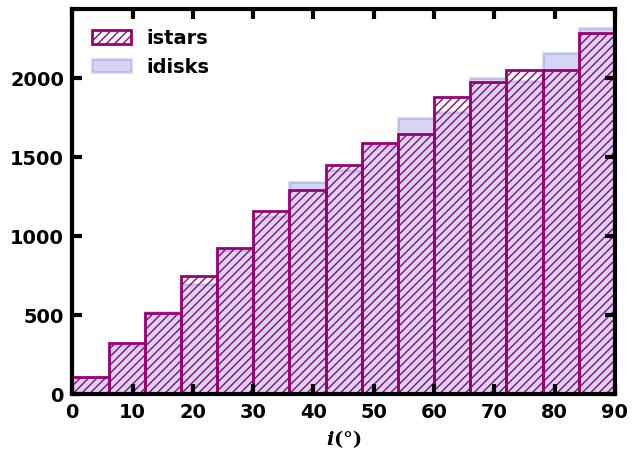

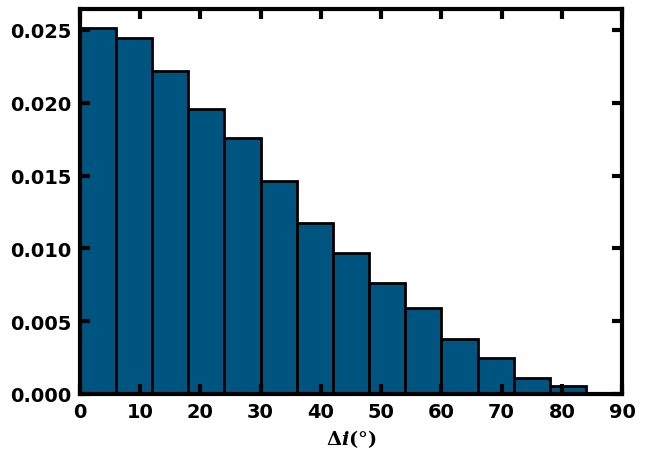

In [101]:
bin_width = 6
hist_bins = np.arange(0, 90 + bin_width, bin_width)
plt.hist(istars, edgecolor='#990073', hatch='////', lw=2, fill=False, bins=hist_bins, label='istars')
plt.hist(idisks, edgecolor='#3333cc', color='#3333cc', lw=2, fill=True, bins=hist_bins, alpha=0.2, label='idisks', zorder=-100)
plt.xlim(0, 90)
plt.xlabel(r'$i  (\degree)$')
plt.legend(loc='upper left')
plt.show()


minimum_obliquities = []
for bep in range(len(istars)):

    istar = istars[bep]
    idisk = idisks[bep]

    minimum_obliquities.append(abs(istar - idisk))

bin_width = 6
power, bounds = np.histogram(minimum_obliquities, bins=np.arange(0, 90+bin_width, bin_width))
power = power/(np.sum(power) * bin_width)
Deltai_x = bounds[:-2]

data_for_Deltai = draw_data_for_kde(Prob_distributions=[power], posterior_x_values=Deltai_x, kde_n_draws=kde_n_draws)  # , verbose=True)
Deltai_kde = generate_kde(data_for_Deltai, Deltai_x, bin_width, kde_bandwidth)

Deltai_color = '#005580'
plt.bar(bounds[:-1], power, edgecolor='#000000', color=Deltai_color, lw=2, align='edge', width=bin_width)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta i  (\degree)$')
plt.show()

In [107]:
bin_width = 4*dx
power, bounds = np.histogram(minimum_obliquities, bins=np.arange(0, 90+bin_width, bin_width))
power = power/(np.sum(power) * bin_width)
Deltai_x = bounds[:-2]

data_for_Deltai = draw_data_for_kde(Prob_distributions=[power], posterior_x_values=Deltai_x, kde_n_draws=int(1e6))  # , verbose=True)
Deltai_kde = generate_kde(data_for_Deltai, Deltai_x, bin_width, kde_bandwidth)
Deltai_kde = Deltai_kde / (np.sum(Deltai_kde) * bin_width)

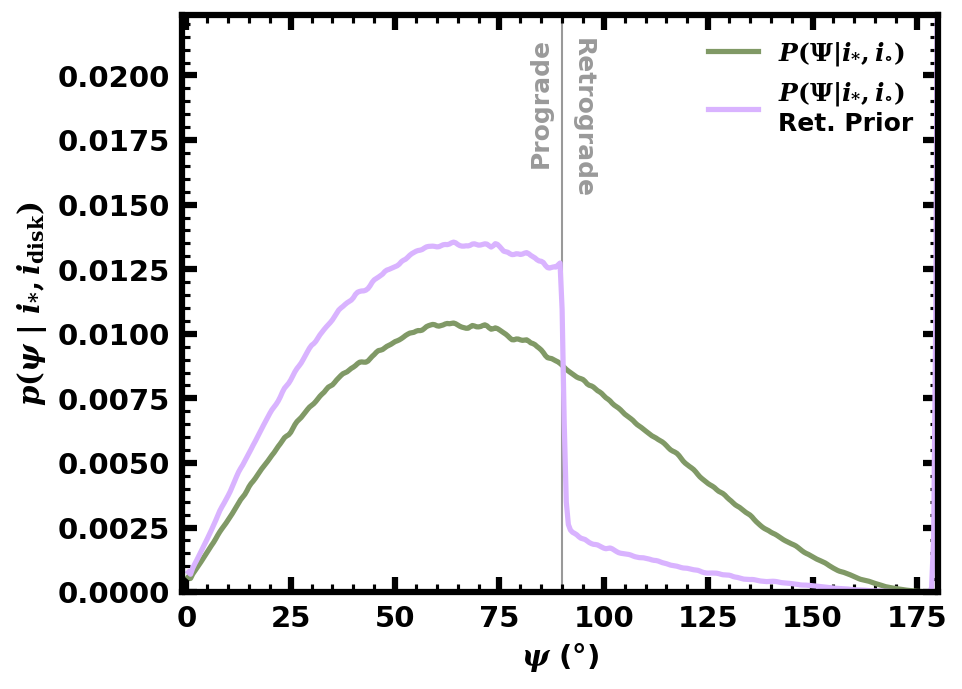

In [109]:
test_fig = plt.figure(figsize=(6.5, 5), dpi=150)
ax = test_fig.add_subplot(111)
ax.minorticks_on()

# ax.set_title(r'$i_{\ast}$ = ' + '{:.1f}'.format(istar) + r'$\degree$    ' + r'$i_{\mathrm{disk}}$ = ' + '{:.1f}'.format(idisk) + r'$\degree$    ' + r'$\Delta i$ = ' + '{:.1f}'.format(abs(istar - idisk)) + r'$\degree$    ', pad=8, x=0.6)
ax.set_xlabel(r'$\psi$ ($\degree$)')
ax.set_ylabel(r'$p(\psi$ | $i_{*}, i_{\mathrm{disk}})$')

xmin, xmax = -1, 181
ymin, ymax = 0, 4*np.mean([blarb for foop in true_obliquities_no_retro_prior for blarb in foop])  # -0.04 * max(ploty), 1.14 * max(ploty)
# print(ymin, ymax)

linecolor = '#809966'  # '#476685'
fillcolor = '#cccc00'  # '#476685'

# ax.plot(Deltai_x, Deltai_kde, color=Deltai_color, label=r'$\Delta i$')

ax.plot(Psi[1:], Psi_kde_no_retro_prior, color=linecolor, label=r'$P(\Psi|i_{*}, i_{\circ})$')
# ax.fill_between(Psi[1:], Psi_kde_no_retro_prior, color=fillcolor, alpha=0.4, label='no retro. prior')

ax.plot(Psi[1:], Psi_kde_yes_retro_prior, color='#d9b3ff', label=r'$P(\Psi|i_{*}, i_{\circ})$' + '\nRet. Prior')
# ax.fill_between(Psi[1:], Psi_kde_yes_retro_prior, color='#d9b3ff', alpha=0.4, label='yes retro. prior')

ax.plot([90, 90], [0, ymax], lw=1, color='#000000', alpha=0.4, zorder = -10)
# ax.plot([np.nanmin(possible_Psis) - dx, np.nanmin(possible_Psis) - dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)
# ax.plot([np.nanmax(possible_Psis) + dx, np.nanmax(possible_Psis) + dx], [0, ymax], ls='--', lw=1, color='#000000', zorder = -10)

ax.text(90 - 5, 0.96 * ymax, 'Prograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=90, color='#000000', alpha=0.4)
ax.text(90 + 5, 0.96 * ymax, 'Retrograde', horizontalalignment='center', verticalalignment='top', fontsize=12, rotation=270, color='#000000', alpha=0.4)

ax.set_xlim(xmin, 180)
ax.set_ylim(ymin, ymax)

ax.legend(loc='upper right', fontsize=12)

plt.show()